In [1]:
from fourrooms import FourRooms
from time import sleep
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Environment with 3 different modes, trivial actions, only hallmark options and both

Random trivial actions

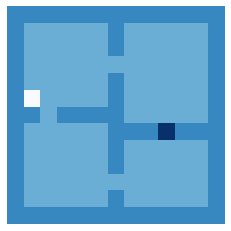

Maximum steps


In [2]:
from fourrooms import EnvMode
env = FourRooms(max_steps=100, start_pos=11, mode=EnvMode.TRIVIAL, rendering=True)
env.reset()
actions = []
while True:
    
    action = np.random.choice(env.action_space)
    print(action)
    state, reward, done, truncated, steps = env.step(action)
    actions.append(action)

    if done or truncated:
        print("Done") if done else print("Maximum steps")  
        break

### Q Learning

In [3]:
epsilon = 0.1
lr = 0.3
gamma = 0.9
nruns = 50


In [4]:
# Discount
discount = 0.9

# Learning rates - termination, intra-option, critic
lr_term = 0.3
lr_intra = 0.3
lr_critic = 0.5

# Epsilon for epsilon-greedy for policy over options
epsilon = 1e-1

# Temperature for softmax
temperature = 1e-2

# Number of runs

# Number of episodes per run
nepisodes = 10000

# Maximum number of steps per episode
nsteps = 1000

# Number of options
noptions = 4

In [5]:
rng = np.random.RandomState(1234)

The main loop for training.

Run 50 - Episodes: 100%|██████████| 10000/10000 [00:44<00:00, 224.64it/s]


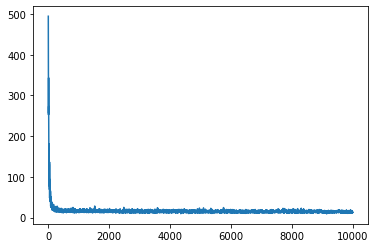

In [30]:
from agents import OptionCritic
env = FourRooms(max_steps=1000, mode=EnvMode.TRIVIAL)

option_critic = OptionCritic(
    rng=rng, 
    temperature=temperature,
    env=env,
    epsilon=epsilon,
    lr_intra=lr_intra,
    lr_term=lr_term, 
    nsteps=nsteps, 
    lr_critic=lr_critic,
    discount=gamma,
    noptions=noptions)

goals, start_pos, steps = option_critic.train(
    nepisodes=nepisodes, 
    nruns=nruns, 
    possible_next_goals=None)

plt.plot(np.arange(nepisodes), np.mean(steps,axis=1))
plt.show()

In [31]:
from utils import postprocess
st_option_critic = postprocess(steps=steps, nepisodes=nepisodes)

In [32]:
from utils import train_model
env = FourRooms(max_steps=1000, mode=EnvMode.TRIVIAL, start_pos=1)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns, start_pos=start_pos)

st_qlearning = postprocess(steps=steps, nepisodes=nepisodes)


Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:18<00:00, 527.90it/s]


In [33]:
env = FourRooms(max_steps=1000, mode=EnvMode.ALL, start_pos=1)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns, start_pos=start_pos)

st_qlearning_all = postprocess(steps=steps, nepisodes=nepisodes)

Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:05<00:00, 1966.62it/s]


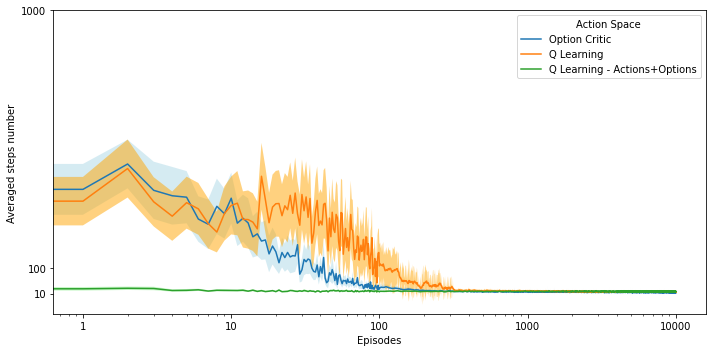

In [34]:
import seaborn as sns
import pandas as pd
def plot_steps(st_option_critic, st_qlearning, st_qlearning_all):
    st_option_critic["Type"] = "Option Critic"
    st_option_critic['Moving_Average'] = st_option_critic['Steps'].rolling(window=10).mean()
    st_option_critic.loc[:100, "Moving_Average"] = st_option_critic.loc[:100, "Steps"]

    st_qlearning["Type"] = "Q Learning"
    st_qlearning['Moving_Average'] = st_qlearning['Steps'].rolling(window=10).mean()
    st_qlearning.loc[:100, "Moving_Average"] = st_qlearning.loc[:100, "Steps"]

    st_qlearning_all["Type"] = "Q Learning - Actions+Options"
    st_qlearning_all['Moving_Average'] = st_qlearning_all['Steps'].rolling(window=10).mean()
    st_qlearning_all.loc[:100, "Moving_Average"] = st_qlearning_all.loc[:100, "Steps"]

    st = pd.concat([st_option_critic, st_qlearning,st_qlearning_all])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    ax.fill_between(st_option_critic["Episodes"], st_option_critic["Moving_Average"]-1.96*st_option_critic["Std"]/np.sqrt(50), st_option_critic["Moving_Average"]+1.96*st_option_critic["Std"]/np.sqrt(50), alpha=0.5, facecolor="Lightblue")
    ax.fill_between(st_qlearning["Episodes"], st_qlearning["Moving_Average"]-1.96*st_qlearning["Std"]/np.sqrt(50), st_qlearning["Moving_Average"]+1.96*st_qlearning["Std"]/np.sqrt(50), alpha=0.5, facecolor="Orange")
    ax.fill_between(st_qlearning_all["Episodes"], st_qlearning_all["Moving_Average"]-1.96*st_qlearning_all["Std"]/np.sqrt(50), st_qlearning_all["Moving_Average"]+1.96*st_qlearning_all["Std"]/np.sqrt(50), alpha=0.5, facecolor="Lightgreen")


    ticks_x = [1, 10, 100, 1000, 10000]
    ticks_y = [10, 100, 1000]

    sns.lineplot(data=st, x="Episodes", y="Moving_Average", hue="Type", ax=ax)
    ax.set(ylabel="Averaged steps number")
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xticks(ticks_x)
    ax.set_xticklabels(ticks_x)


    ax.set_yticks(ticks_y)
    ax.set_yticklabels(ticks_y)

    ax.legend(title="Action Space")
    fig.tight_layout()
    plt.show()
plot_steps(st_option_critic, st_qlearning, st_qlearning_all)

Displaying termination probabilities.

Run: 49


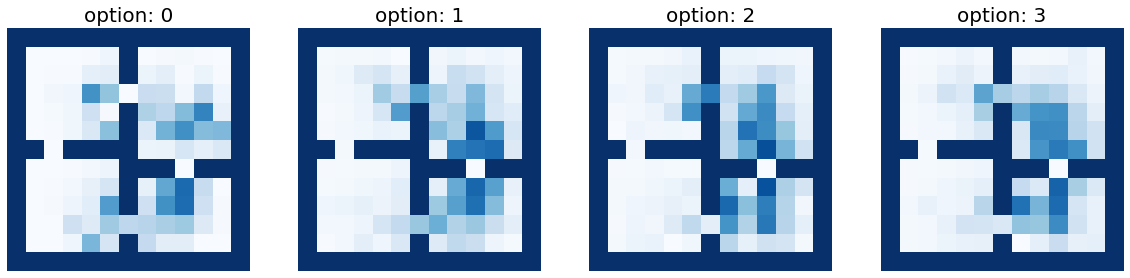

In [35]:
for run in range(nruns):
    
    termination_maps = [env.occupancy.astype('float64') for _ in range(noptions)]
    
    for option in range(noptions):
        state = 0
        for i in range(13):
            for j in range(13):
                if termination_maps[option][i,j] == 0:
                    termination_maps[option][i,j] = option_critic.option_terminations_list[run][option].sigmoid(state)
                    state += 1

    clear_output(True)
    print('Run: {}'.format(run))
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('option: 0', fontsize=20)
    plt.imshow(termination_maps[0], cmap='Blues')
    plt.axis('off')
    plt.subplot(142)
    plt.title('option: 1', fontsize=20)
    plt.imshow(termination_maps[1], cmap='Blues')
    plt.axis('off')
    plt.subplot(143)
    plt.title('option: 2', fontsize=20)
    plt.imshow(termination_maps[2], cmap='Blues')
    plt.axis('off')
    plt.subplot(144)
    plt.title('option: 3', fontsize=20)
    plt.imshow(termination_maps[3], cmap='Blues')
    plt.axis('off')
    plt.show()
    sleep(2)

In [32]:
def plot_values(qtable):
    map_size = 13
    qtable_max = qtable.max(axis=1).flatten()#.reshape(map_size, map_size)
    qtable_val_max = env.occupancy.copy()
    qtable_val_max[qtable_val_max == 0] = 2
    qtable_val_max[qtable_val_max == 1] = np.finfo(float).eps
    qtable_val_max = qtable_val_max.flatten().astype(float)
    qtable_best_action = np.argmax(qtable, axis=1).flatten()#.reshape(map_size, map_size)

    directions = {0: "↑", 1: "↓", 2: "←", 3: "→", 4: "L", 5: "R", 6: "T", 7:"B"}
    qtable_directions = np.empty(13*13, dtype=str)

    eps = np.finfo(float).eps
    i = 0
    for idx, val in enumerate(qtable_val_max):
        if val == 2:
            qtable_val_max[idx] = qtable_max[i]
            if qtable_max[i] > eps:
                qtable_directions[idx] = directions[qtable_best_action[i]]
            i += 1
    qtable_val_max = qtable_val_max.reshape((map_size, map_size))
    qtable_directions = qtable_directions.reshape((map_size, map_size))
    return qtable_val_max, qtable_directions
    


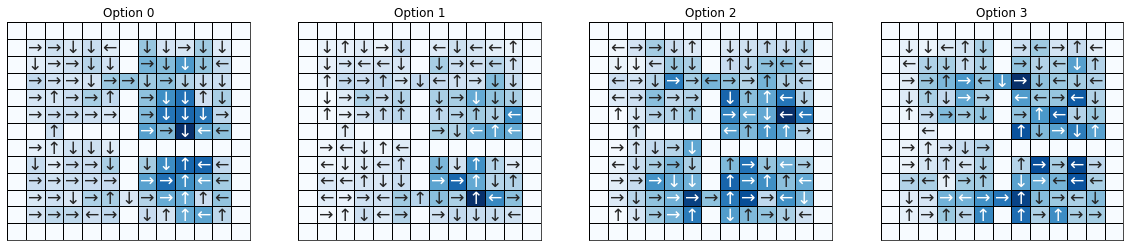

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
cbar = False
for i in range(noptions):
    qtable = np.array([option_critic.actor.option_policies[i].Q_U(j) for j in range(104)])
    qtable_val_max, qtable_directions = plot_values(qtable)
    
    if i == 3:
        cbar = False
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[i],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor ="black",
        xticklabels=[],
        yticklabels=[],
        cbar=cbar,
        annot_kws={"fontsize": "xx-large"}
    ).set(title=f"Option {i}")
    for _, spine in ax[i].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
plt.show()

The goal is the east doorway.

Goal change after 1000 episodes, same starting position

Run 1 - Episodes:  50%|█████     | 1003/2000 [00:14<00:23, 43.31it/s]

New goal: 80


Run 2 - Episodes:  51%|█████     | 1012/2000 [00:12<00:09, 106.19it/s]

New goal: 92


Run 3 - Episodes:  51%|█████     | 1024/2000 [00:18<00:08, 119.86it/s]

New goal: 70


Run 4 - Episodes:  51%|█████     | 1018/2000 [00:12<00:08, 113.41it/s]

New goal: 69


Run 5 - Episodes:  50%|████▉     | 995/2000 [00:12<00:08, 125.23it/s]

New goal: 92


Run 6 - Episodes:  51%|█████     | 1013/2000 [00:15<00:10, 98.29it/s]

New goal: 90


Run 7 - Episodes:  50%|█████     | 1007/2000 [00:13<00:07, 139.66it/s]

New goal: 69


Run 8 - Episodes:  50%|████▉     | 997/2000 [00:10<00:06, 163.30it/s]

New goal: 90


Run 9 - Episodes:  51%|█████     | 1018/2000 [00:11<00:07, 132.10it/s]

New goal: 78


Run 10 - Episodes:  51%|█████     | 1016/2000 [00:14<00:08, 122.65it/s]

New goal: 80


Run 11 - Episodes:  51%|█████     | 1016/2000 [00:09<00:08, 122.10it/s]

New goal: 71


Run 12 - Episodes:  51%|█████     | 1013/2000 [00:09<00:07, 136.39it/s]

New goal: 80


Run 13 - Episodes:  50%|█████     | 1002/2000 [00:10<00:08, 122.32it/s]

New goal: 93


Run 14 - Episodes:  50%|█████     | 1001/2000 [00:12<00:10, 98.45it/s]

New goal: 88


Run 15 - Episodes:  50%|████▉     | 995/2000 [00:13<00:11, 88.88it/s] 

New goal: 102


Run 16 - Episodes:  50%|█████     | 1000/2000 [01:00<01:11, 14.07it/s]

New goal: 71


Run 17 - Episodes:  50%|████▉     | 999/2000 [01:21<01:30, 11.05it/s]

New goal: 69


Run 18 - Episodes:  50%|█████     | 1000/2000 [01:30<01:01, 16.22it/s]

New goal: 88


Run 19 - Episodes:  50%|█████     | 1000/2000 [01:12<00:41, 23.96it/s]

New goal: 90


Run 20 - Episodes:  50%|████▉     | 999/2000 [01:13<01:05, 15.26it/s]

New goal: 71


Run 21 - Episodes:  50%|████▉     | 999/2000 [01:15<00:45, 22.08it/s]

New goal: 68


Run 22 - Episodes:  50%|█████     | 1000/2000 [01:16<00:48, 20.56it/s]

New goal: 102


Run 23 - Episodes:  50%|█████     | 1004/2000 [01:42<00:58, 17.12it/s]

New goal: 101


Run 24 - Episodes:  50%|█████     | 1002/2000 [01:32<01:01, 16.17it/s]

New goal: 90


Run 25 - Episodes:  50%|█████     | 1003/2000 [01:31<01:06, 15.02it/s]

New goal: 89


Run 26 - Episodes:  50%|█████     | 1002/2000 [01:07<00:49, 19.99it/s]

New goal: 99


Run 27 - Episodes:  51%|█████     | 1018/2000 [00:36<00:10, 92.71it/s]

New goal: 89


Run 28 - Episodes:  50%|█████     | 1006/2000 [00:09<00:09, 100.62it/s]

New goal: 78


Run 29 - Episodes:  50%|█████     | 1007/2000 [00:10<00:07, 139.56it/s]

New goal: 80


Run 30 - Episodes:  50%|█████     | 1010/2000 [00:12<00:09, 107.49it/s]

New goal: 89


Run 31 - Episodes:  50%|████▉     | 998/2000 [00:11<00:06, 160.96it/s]

New goal: 69


Run 32 - Episodes:  50%|████▉     | 993/2000 [00:09<00:05, 169.07it/s]

New goal: 103


Run 33 - Episodes:  50%|████▉     | 998/2000 [00:13<00:08, 122.12it/s]

New goal: 88


Run 34 - Episodes:  50%|█████     | 1001/2000 [00:09<00:06, 161.75it/s]

New goal: 81


Run 35 - Episodes:  50%|█████     | 1002/2000 [00:11<00:07, 125.59it/s]

New goal: 103


Run 36 - Episodes:  51%|█████     | 1011/2000 [00:12<00:09, 104.07it/s]

New goal: 82


Run 37 - Episodes:  50%|████▉     | 992/2000 [00:13<00:07, 128.35it/s]

New goal: 71


Run 38 - Episodes:  50%|█████     | 1007/2000 [00:09<00:08, 119.24it/s]

New goal: 102


Run 39 - Episodes:  51%|█████     | 1015/2000 [00:12<00:08, 114.00it/s]

New goal: 81


Run 40 - Episodes:  51%|█████▏    | 1025/2000 [00:10<00:06, 147.54it/s]

New goal: 81


Run 41 - Episodes:  51%|█████▏    | 1027/2000 [00:11<00:06, 143.99it/s]

New goal: 80


Run 42 - Episodes:  51%|█████▏    | 1029/2000 [00:10<00:07, 129.51it/s]

New goal: 70


Run 43 - Episodes:  50%|████▉     | 998/2000 [00:12<00:07, 139.23it/s]

New goal: 100


Run 44 - Episodes:  50%|█████     | 1007/2000 [00:15<00:09, 109.71it/s]

New goal: 101


Run 45 - Episodes:  51%|█████     | 1017/2000 [00:11<00:07, 122.92it/s]

New goal: 93


Run 46 - Episodes:  50%|█████     | 1005/2000 [01:33<00:44, 22.33it/s]

New goal: 71


Run 47 - Episodes:  51%|█████     | 1023/2000 [00:36<00:05, 188.83it/s]

New goal: 92


Run 48 - Episodes:  52%|█████▏    | 1031/2000 [00:13<00:05, 168.01it/s]

New goal: 70


Run 49 - Episodes:  50%|█████     | 1001/2000 [00:08<00:06, 146.38it/s]

New goal: 99


Run 50 - Episodes:  51%|█████     | 1012/2000 [00:10<00:08, 112.18it/s]

New goal: 79


Run 50 - Episodes: 100%|██████████| 2000/2000 [00:22<00:00, 87.73it/s] 


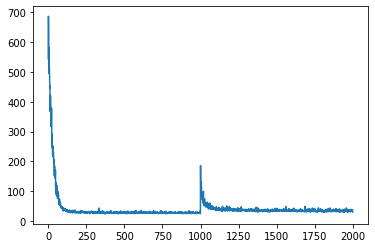

In [9]:
env = FourRooms(max_steps=1000, mode=EnvMode.TRIVIAL, start_pos=1)
nruns = 50
nepisodes = 2000
possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]
option_critic = OptionCritic(
    rng=rng, 
    temperature=temperature,
    env=env,
    epsilon=epsilon,
    lr_intra=lr_intra,
    lr_term=lr_term, 
    nsteps=nsteps, 
    lr_critic=lr_critic,
    discount=gamma,
    noptions=noptions)

goals, start_pos, steps = option_critic.train(
    nepisodes=nepisodes, 
    nruns=nruns, 
    possible_next_goals=possible_next_goals)

plt.plot(np.arange(nepisodes), np.mean(steps,axis=1))
plt.show()

In [16]:
st_option_critic = postprocess(steps=steps, nepisodes=nepisodes)

In [17]:
step_sequence = []
for i in range(len(goals)):
    env = FourRooms(max_steps=1000, mode=EnvMode.TRIVIAL, start_pos=1)
    clear_output(True)
    qtables, rewards, new_steps = train_model(env, lr, gamma, epsilon, 2000, 1, goals[i])
    step_sequence = np.concatenate([new_steps, step_sequence], axis=1) if len(step_sequence) > 0 else new_steps
st_qlearning = postprocess(steps=step_sequence, nepisodes=nepisodes)

Run 1/1 - Episodes:  48%|████▊     | 956/2000 [00:01<00:01, 649.64it/s]

New goal:  79


Run 1/1 - Episodes: 100%|██████████| 2000/2000 [00:04<00:00, 433.58it/s]


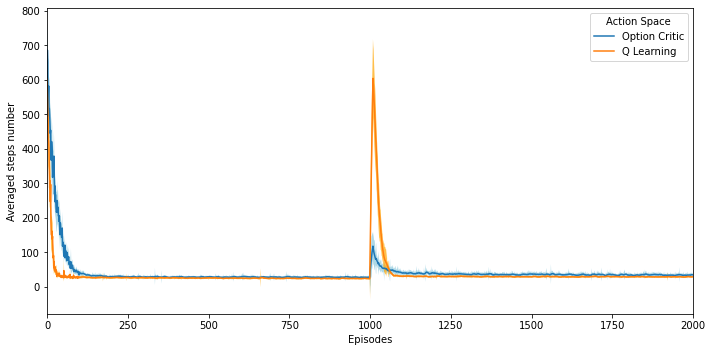

In [30]:
st_option_critic["Type"] = "Option Critic"
st_option_critic['Moving_Average'] = st_option_critic['Steps'].rolling(window=10).mean()
st_option_critic.loc[:100, "Moving_Average"] = st_option_critic.loc[:100, "Steps"]

st_qlearning["Type"] = "Q Learning"
st_qlearning['Moving_Average'] = st_qlearning['Steps'].rolling(window=10).mean()
st_qlearning.loc[:100, "Moving_Average"] = st_qlearning.loc[:100, "Steps"]

st = pd.concat([st_option_critic, st_qlearning])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.fill_between(st_option_critic["Episodes"], st_option_critic["Moving_Average"]-1.96*st_option_critic["Std"]/np.sqrt(50), st_option_critic["Moving_Average"]+1.96*st_option_critic["Std"]/np.sqrt(50), facecolor="Lightblue")
ax.fill_between(st_qlearning["Episodes"], st_qlearning["Moving_Average"]-1.96*st_qlearning["Std"]/np.sqrt(50), st_qlearning["Moving_Average"]+1.96*st_qlearning["Std"]/np.sqrt(50), alpha=0.7, facecolor="Orange")
    

ticks_x = [1, 10, 100, 1000, 10000]
ticks_y = [10, 100, 1000]

sns.lineplot(data=st, x="Episodes", y="Moving_Average", hue="Type", ax=ax)
ax.set(ylabel="Averaged steps number")
ax.set_xlim(left=0, right=2000)
#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_xticks(ticks_x)
#ax.set_xticklabels(ticks_x)


# ax.set_yticks(ticks_y)
# ax.set_yticklabels(ticks_y)

ax.legend(title="Action Space")
fig.tight_layout()
plt.show()

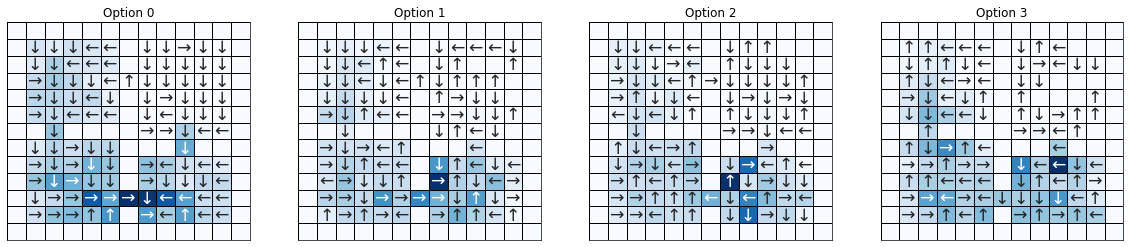

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
cbar = False
for i in range(noptions):
    qtable = np.array([option_critic.actor.option_policies[i].Q_U(j) for j in range(104)])
    qtable_val_max, qtable_directions = plot_values(qtable)
    
    if i == 3:
        cbar = False
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[i],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor ="black",
        xticklabels=[],
        yticklabels=[],
        cbar=cbar,
        annot_kws={"fontsize": "xx-large"}
    ).set(title=f"Option {i}")
    for _, spine in ax[i].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
plt.show()

Run: 49


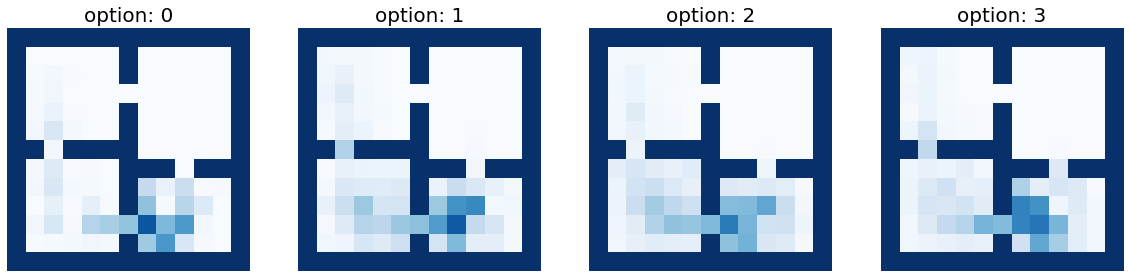

In [36]:
for run in range(nruns):
    
    termination_maps = [env.occupancy.astype('float64') for _ in range(noptions)]
    
    for option in range(noptions):
        state = 0
        for i in range(13):
            for j in range(13):
                if termination_maps[option][i,j] == 0:
                    termination_maps[option][i,j] = option_critic.option_terminations_list[run][option].sigmoid(state)
                    state += 1

    clear_output(True)
    print('Run: {}'.format(run))
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('option: 0', fontsize=20)
    plt.imshow(termination_maps[0], cmap='Blues')
    plt.axis('off')
    plt.subplot(142)
    plt.title('option: 1', fontsize=20)
    plt.imshow(termination_maps[1], cmap='Blues')
    plt.axis('off')
    plt.subplot(143)
    plt.title('option: 2', fontsize=20)
    plt.imshow(termination_maps[2], cmap='Blues')
    plt.axis('off')
    plt.subplot(144)
    plt.title('option: 3', fontsize=20)
    plt.imshow(termination_maps[3], cmap='Blues')
    plt.axis('off')
    plt.show()
